In [1]:
import torchvision.transforms as transforms
from torchvision import datasets, models
import random
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import os
import time
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
os.listdir("./datasets/incidents/train/")

['ice storm',
 'car accident',
 'oil spill',
 'wildfire',
 'earthquake',
 'airplane accident',
 'volcanic eruption',
 'collapsed',
 'tornado',
 'nuclear explosion',
 'bicycle accident',
 'flooded']

In [3]:
def AugmentImage(img):
        
    img = transforms.Resize(256)(img)
    
    transform = transforms.Compose([

        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.RandomCrop(200),
        transforms.RandomAffine(degrees=(-50,50)),
    ])
    
    return transforms.Resize((256,256))(transform(img))

In [4]:
class Incidents12(datasets.VisionDataset):
    def __init__(self, root, train=True, transform=None):
        super().__init__(root, transform=transform)

        self.data = []
        self.targets = []
        self.errors = []
        self.train = train

        path = f"{root}/train/" if self.train else f"{root}/test/"
        
        # Load images from disk
        self.classes = os.listdir(path)
        paths = [path + self.classes[i] + '/' for i in range(len(self.classes))]

        for p in paths:
            for _, _, files in os.walk(p):
                for filename in files:
                    try:
                        img = Image.open(p+filename).convert("RGB")
                        self.data.append(img)
                        self.targets.append(paths.index(p))
                    except (UnidentifiedImageError, FileNotFoundError):
                        self.errors.append(p+filename)

        # Oversampling to get larger training set
        
        if self.train:
            data_aug = []
            targets_aug = []
            classes_count = {i: 0 for i in range(len(self.classes))}
            for target in self.targets:
                classes_count[target] += 1
            max_class = max(classes_count, key=classes_count.get)
            max_val = classes_count[max_class]
            
            div = [1000//e for e in list(classes_count.values())]
            diff = [1000 - e for e in list(classes_count.values())]
            
            for i in range(len(self.data)):
                if diff[self.targets[i]] > 0:
                    for j in range(div[self.targets[i]]):
                        data_aug.append(AugmentImage(self.data[i]))
                        targets_aug.append(self.targets[i])
                    diff[self.targets[i]] -= div[self.targets[i]]
            
            self.data += data_aug
            self.targets += targets_aug
                    

            #df = pd.DataFrame(data={"Image": self.data, "Label": self.targets})
            #samples_class = [df[df["Label"] == i] for i in range(len(self.classes))]
            #classes_over = [AugmentImage(samples_class[i]).sample(df[df["Label"] == max_class].shape[0], replace=True) for i in range(len(self.classes))]
            #new_df = pd.concat(classes_over, axis=0).reset_index()

            #self.data = new_df["Image"]
            #self.targets = new_df["Label"]
        
            
    def __getitem__(self, index: int): 
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            img = self.transform(img)
            img = img.numpy().transpose((1, 2, 0))

        return img, target

    def __len__(self):
        return(len(self.data))

    def to_dataframe(self):
        tensor_images = [self[i][0] for i in range(len(self.data))]
        return(pd.DataFrame(data={"Image": tensor_images, "Label": self.targets}))

In [5]:
transform = transforms.Compose([
    # resize
    transforms.Resize(256),
    # center-crop
    transforms.CenterCrop(224),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.04544269, 0.04544269, 0.04544269],
                         [0.21317291, 0.21317291, 0.21317291])
])

In [6]:
train_dataset = Incidents12("datasets/incidents/", transform=transform)
test_dataset = Incidents12("datasets/incidents/", train=False, transform=transform)

In [7]:
len(train_dataset)+len(test_dataset)

13482

In [8]:
train_df = train_dataset.to_dataframe()
# len(test_dataset)
train_df

,Image,Label
0,"[[[1.7736152, 1.8104075, 1.7184266], [2.325501...",0
1,"[[[1.8104075, 1.9207847, 2.1783314], [1.608049...",0
2,"[[[0.5226746, 0.46748602, 0.37550512], [0.5594...",0
3,"[[[3.2821026, 3.4844606, 3.8155918], [3.263706...",0
4,"[[[2.3071046, 2.2519162, 2.2519162], [2.031161...",0
...,...,...
12005,"[[[3.6684225, 3.7236109, 3.8523843], [3.650026...",11
12006,"[[[-0.21317291, -0.21317291, -0.21317291], [-0...",11
12007,"[[[-0.21317291, -0.21317291, -0.21317291], [-0...",11
12008,"[[[-0.21317291, -0.21317291, -0.21317291], [-0...",11


In [9]:
class_sample_count = np.unique(train_dataset.targets, return_counts=True)[1]
weights = 1 / torch.Tensor(class_sample_count)

samples_weight = np.array([weights[t] for t in train_dataset.targets])
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [10]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, sampler=sampler, num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, num_workers=4)

In [11]:
train_size = len(train_dataset)
test_size = len(test_dataset)

In [12]:
def imshow(inp, title=None):
    inp = np.array(inp)
    mean = np.array([0.04544269, 0.04544269, 0.04544269])
    std = np.array([0.21317291, 0.21317291, 0.21317291])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

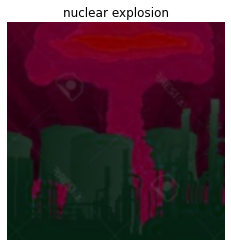

In [13]:
r = random.randint(0,len(train_dataset.data))
imshow(train_dataset[r][0], train_dataset.classes[train_dataset[r][1]])

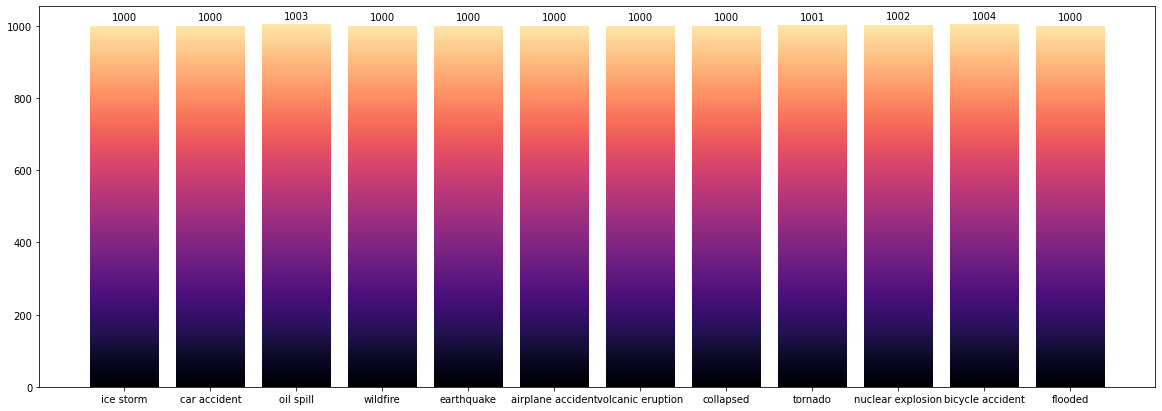

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
rects = plt.bar(train_dataset.classes,train_df["Label"].value_counts().sort_index())

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, '%d'%int(height),
                ha='center', va='bottom')

autolabel(rects)

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin=ymin, vmax=ymax, cmap='magma')
    ax.axis([xmin, xmax, ymin, ymax])

gradientbars_sliced(rects)
plt.show()

### Selecting a device for the Neural Networks

In [15]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')  # training with either cpu or cuda
# device = torch.device('cpu')

## Alexnet

In [29]:
alexnet = models.alexnet(pretrained=True)

# freeze the layers
for param in alexnet.parameters():
    param.requires_grad = False

# Modify the last layer
number_features = alexnet.classifier[6].in_features
features = list(alexnet.classifier.children())[:-1]  # Remove last layer
features.extend([torch.nn.Linear(number_features, len(train_dataset.classes))])
alexnet.classifier = torch.nn.Sequential(*features)

alexnet = alexnet.to(device)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
criterion = torch.nn.CrossEntropyLoss(weight=weights).to(device)
optimizer_ft = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

In [31]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        train_loss = 0

        # Iterate over data.
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.permute(0, 3, 2, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        print('{} loss: {:.4f}'.format(
               'Train', train_loss / train_size))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

    return model

In [32]:
alexnet = train_model(alexnet, criterion, optimizer_ft, num_epochs=10)

----------
Epoch 0/9
Train loss: 2.0511
----------
Epoch 1/9
Train loss: 1.5417
----------
Epoch 2/9
Train loss: 1.3163
----------
Epoch 3/9
Train loss: 1.0989
----------
Epoch 4/9
Train loss: 0.9617
----------
Epoch 5/9
Train loss: 0.8076
----------
Epoch 6/9
Train loss: 0.7407
----------
Epoch 7/9
Train loss: 0.6166
----------
Epoch 8/9
Train loss: 0.5683
----------
Epoch 9/9
Train loss: 0.4899
Training complete in 4m 27s


In [43]:
correct = 0
total = 0
alexnet.eval()

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0, 3, 2, 1)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Alexnet algorithm over the training set of {} images : {}%.".format(4*len(trainloader), 100*correct/total))

Accuracy of Alexnet algorithm over the training set of 12012 images : 86.81931723563697%.


In [44]:
correct = 0
total = 0
alexnet.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0, 3, 2, 1)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Alexnet algorithm over the testing set of {} images : {}%.".format(4*len(testloader), 100*correct/total))

Accuracy of Alexnet algorithm over the testing set of 1472 images : 62.63586956521739%.


In [24]:
def viz_images(model, n_preds=8):
    n_preds += n_preds % 4
    n_cols = 4
    n_rows = n_preds//n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,7))
    plt.subplots_adjust(bottom=1.8, top=3)

    was_training = model.training
    model.eval()
    i = 0
    with torch.no_grad():
        for (_, data) in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.permute(0,3,2,1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            inputs = inputs.permute(0,3,2,1)
            for j in range(n_cols):
                inp = np.array(inputs.cpu().data[j])
                mean = np.array([0.04544269, 0.04544269, 0.04544269])
                std = np.array([0.21317291, 0.21317291, 0.21317291])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                axs[i][j].set_title('predicted: {}'.format(test_dataset.classes[preds[j]]))
                axs[i][j].imshow(inp) 
                if 4*i+j == n_preds:
                    model.train(mode=was_training)
                    return
            i += 1
            if i == n_rows:
                return
        model.train(mode=was_training)

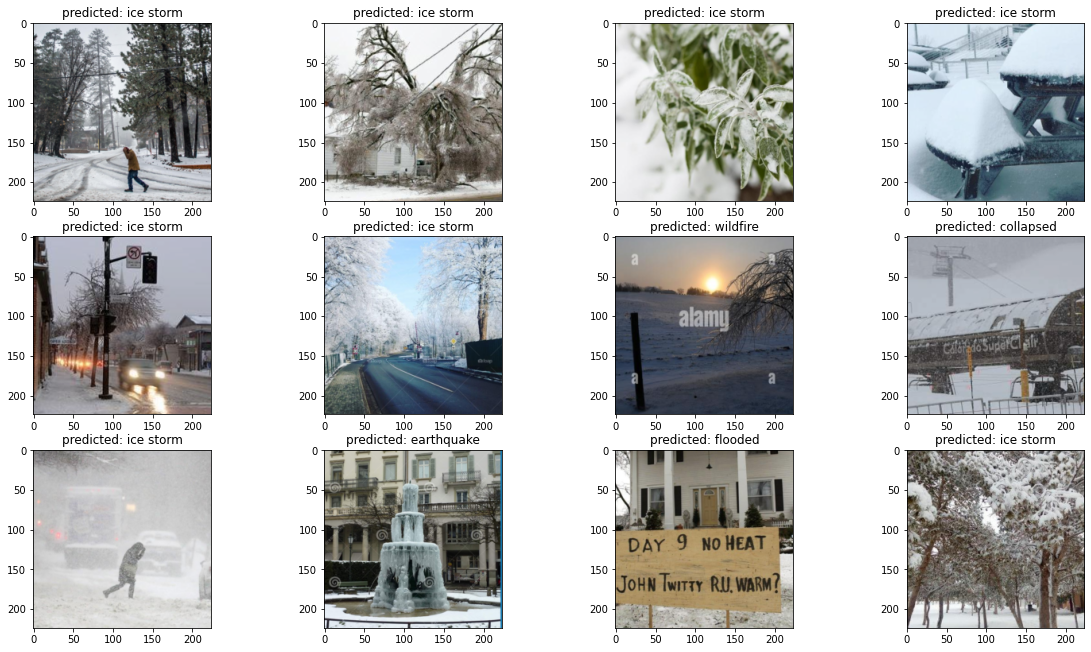

In [62]:
viz_images(alexnet,12)

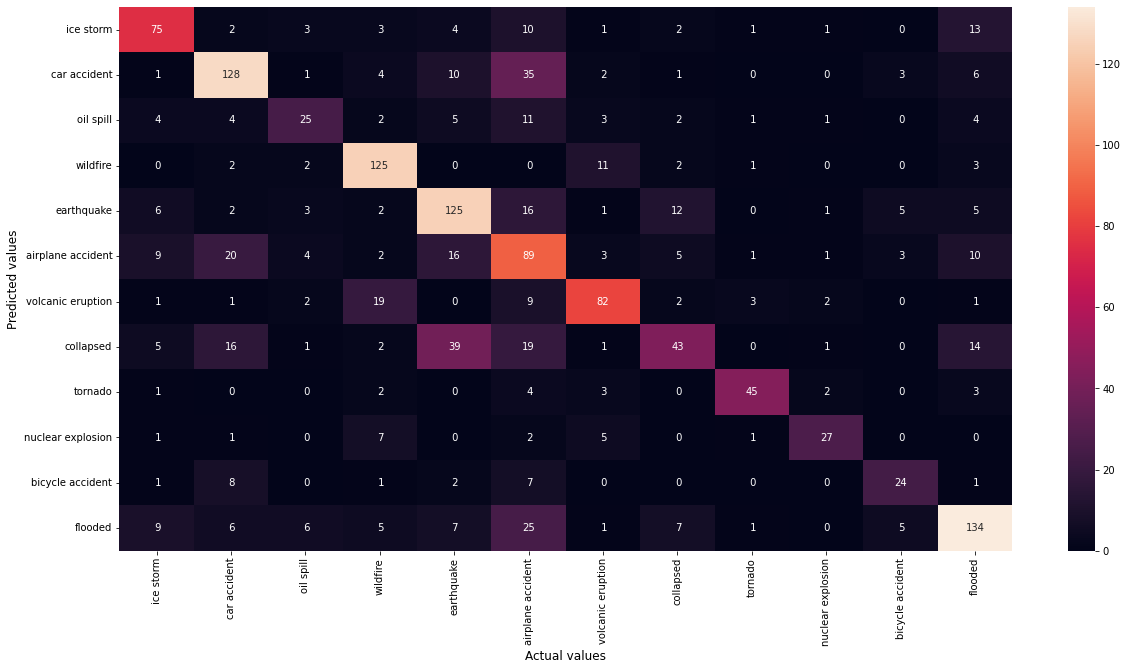

In [45]:
y_pred = []
y_true = []

# iterate over test data
for data in testloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs = inputs.permute(0, 3, 2, 1)
    labels = labels.data.cpu().numpy()

    output = alexnet(inputs) 
    output = torch.max(output, 1)[1].data.cpu().numpy()

    y_pred.extend(output) 
    y_true.extend(labels) 

classes = train_dataset.classes

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes], columns=[i for i in classes])

fig, ax = plt.subplots(figsize=(20, 10))
s = sn.heatmap(df_cm, annot=True, fmt='2')
s.set_xlabel('Actual values', fontsize=12)
s.set_ylabel('Predicted values', fontsize=12)
plt.show()

In [46]:
print(classification_report(y_true, y_pred,target_names=classes))

                   precision    recall  f1-score   support

        ice storm       0.66      0.65      0.66       115
     car accident       0.67      0.67      0.67       191
        oil spill       0.53      0.40      0.46        62
         wildfire       0.72      0.86      0.78       146
       earthquake       0.60      0.70      0.65       178
airplane accident       0.39      0.55      0.46       163
volcanic eruption       0.73      0.67      0.70       122
        collapsed       0.57      0.30      0.40       141
          tornado       0.83      0.75      0.79        60
nuclear explosion       0.75      0.61      0.67        44
 bicycle accident       0.60      0.55      0.57        44
          flooded       0.69      0.65      0.67       206

         accuracy                           0.63      1472
        macro avg       0.65      0.61      0.62      1472
     weighted avg       0.63      0.63      0.62      1472



## VGG Model

In [37]:
vgg16 = models.vgg16(pretrained=True)
# freeze the layers
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the last layer
number_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(train_dataset.classes))])
vgg16.classifier = torch.nn.Sequential(*features)

vgg16 = vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
vgg16 = train_model(vgg16, criterion, optimizer, num_epochs=10)

----------
Epoch 0/9
Train loss: 1.2340
----------
Epoch 1/9
Train loss: 0.9336
----------
Epoch 2/9
Train loss: 0.8397
----------
Epoch 3/9
Train loss: 0.7175
----------
Epoch 4/9
Train loss: 0.6504
----------
Epoch 5/9
Train loss: 0.5952
----------
Epoch 6/9
Train loss: 0.5491
----------
Epoch 7/9
Train loss: 0.5045
----------
Epoch 8/9
Train loss: 0.4736
----------
Epoch 9/9
Train loss: 0.4167
Training complete in 15m 59s


In [39]:
correct = 0
total = 0
vgg16.eval()

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0, 3, 2, 1)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of VGG algorithm over the training set of {} images : {}%.".format(4*len(trainloader), 100*correct/total))

Accuracy of VGG algorithm over the training set of 12012 images : 86.1698584512906%.


In [40]:
correct = 0
total = 0
vgg16.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0, 3, 2, 1)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of VGG algorithm over the testing set of {} images : {}%.".format(4*len(testloader), 100*correct/total))

Accuracy of VGG algorithm over the testing set of 1472 images : 66.37228260869566%.


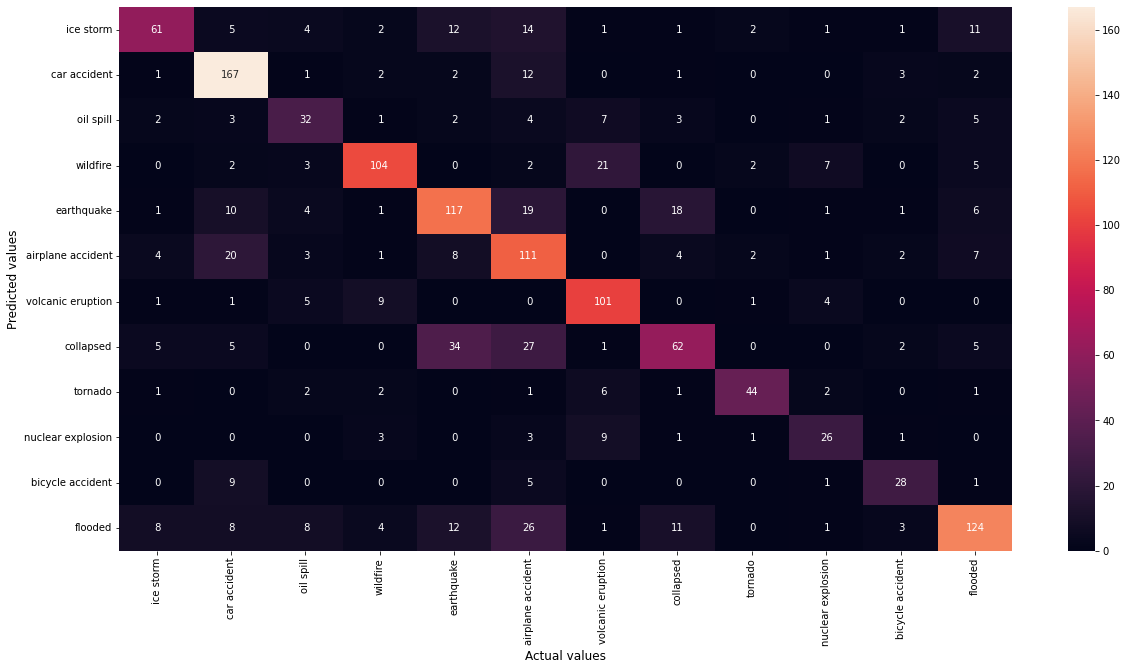

In [41]:
y_pred = []
y_true = []

# iterate over test data
for data in testloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs = inputs.permute(0, 3, 2, 1)
    labels = labels.data.cpu().numpy()

    output = vgg16(inputs) 
    output = torch.max(output, 1)[1].data.cpu().numpy()

    y_pred.extend(output) 
    y_true.extend(labels) 

classes = train_dataset.classes

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes], columns=[i for i in classes])

fig, ax = plt.subplots(figsize=(20, 10))
s = sn.heatmap(df_cm, annot=True, fmt='2')
s.set_xlabel('Actual values', fontsize=12)
s.set_ylabel('Predicted values', fontsize=12)
plt.show()

In [42]:
print(classification_report(y_true, y_pred,target_names=classes))

                   precision    recall  f1-score   support

        ice storm       0.73      0.53      0.61       115
     car accident       0.73      0.87      0.79       191
        oil spill       0.52      0.52      0.52        62
         wildfire       0.81      0.71      0.76       146
       earthquake       0.63      0.66      0.64       178
airplane accident       0.50      0.68      0.57       163
volcanic eruption       0.69      0.83      0.75       122
        collapsed       0.61      0.44      0.51       141
          tornado       0.85      0.73      0.79        60
nuclear explosion       0.58      0.59      0.58        44
 bicycle accident       0.65      0.64      0.64        44
          flooded       0.74      0.60      0.66       206

         accuracy                           0.66      1472
        macro avg       0.67      0.65      0.65      1472
     weighted avg       0.67      0.66      0.66      1472



## Efficient net

In [16]:
effnet = models.efficientnet_b4(pretrained=True)

# freeze the layers
for param in effnet.parameters():
    param.requires_grad = False

# Modify the last layer
number_features = effnet.classifier[1].in_features
features = list(effnet.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(train_dataset.classes))])
effnet.classifier = torch.nn.Sequential(*features)

effnet = effnet.to(device)
effnet.eval()

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

In [20]:
optimizer = optim.SGD(effnet.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss(weight=weights).to(device)
effnet = train_model(effnet, criterion, optimizer, num_epochs=10)

----------
Epoch 0/9
Train loss: 1.6439
----------
Epoch 1/9
Train loss: 1.1371
----------
Epoch 2/9
Train loss: 1.0027
----------
Epoch 3/9
Train loss: 0.9272
----------
Epoch 4/9
Train loss: 0.8727
----------
Epoch 5/9
Train loss: 0.8380
----------
Epoch 6/9
Train loss: 0.7918
----------
Epoch 7/9
Train loss: 0.7778
----------
Epoch 8/9
Train loss: 0.7382
----------
Epoch 9/9
Train loss: 0.7325
Training complete in 10m 17s


In [47]:
correct = 0
total = 0
effnet.eval()

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0, 3, 2, 1)
        outputs = effnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Effnet algorithm over the training set of {} images : {}%.".format(4*len(trainloader), 100*correct/total))

Accuracy of Effnet algorithm over the training set of 12012 images : 77.751873438801%.


In [48]:
correct = 0
total = 0
effnet.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0, 3, 2, 1)
        outputs = effnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Effnet algorithm over the testing set of {} images : {}%.".format(4*len(testloader), 100*correct/total))

Accuracy of Effnet algorithm over the testing set of 1472 images : 75.81521739130434%.


In [ ]:
y_pred = []
y_true = []

# iterate over test data
for data in testloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs = inputs.permute(0, 3, 2, 1)
    labels = labels.data.cpu().numpy()

    output = effnet(inputs) 
    output = torch.max(output, 1)[1].data.cpu().numpy()

    y_pred.extend(output) 
    y_true.extend(labels) 

classes = train_dataset.classes

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes], columns=[i for i in classes])

fig, ax = plt.subplots(figsize=(20, 10))
s = sn.heatmap(df_cm, annot=True, fmt='2')
s.set_xlabel('Actual values', fontsize=12)
s.set_ylabel('Predicted values', fontsize=12)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred,target_names=classes))

In [105]:
inception = models.inception_v3(pretrained=True)
# freeze the layers
for param in inception.parameters():
    param.requires_grad = False

# Modify the last layer
number_features = inception.fc.in_features
features = list(inception.fc.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(train_dataset.classes))])
inception.fc = torch.nn.Sequential(*features)

inception = inception.to(device)
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [106]:
optimizer_inception = optim.SGD(inception.parameters(), lr=0.001, momentum=0.9)
inception = train_model(inception, criterion, optimizer_inception, num_epochs=10)

----------
Epoch 0/9


KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0
inception.eval()

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0, 3, 2, 1)
        outputs = inception(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Inception algorithm over the training set of {} images : {}%.".format(len(trainloader), 100*correct/total))

In [ ]:
correct = 0
total = 0
inception.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0,3,2,1)
        outputs = inception(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Inception algorithm over the testing set of {} images : {}%.".format(len(testloader), 100*correct/total))